
# ARSENL Backscatter Experiments

Grant Kirchhoff
05-31-2022
University of Colorado Boulder

Fit the photon arrival rate to Gaussian profiles from ARSENL INPHAMIS lidar. 

IMPORTANT: Set data path settings in
'load_ARSENL_data.py' first.

In [1]:
import numpy as np
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt
import torch
from scipy import stats
import os
import xarray as xr

from load_ARSENL_data import load_INPHAMIS_data, data_dir, fname, picklename

In [2]:
### CONSTANTS ####
c = 299792458                      # [m/s] Speed of light
tstamp_int = 25                    # Timestamp interval (e.g., timestamp recorded in intervals of 25)
max_rollover = 2**25 * tstamp_int  # [ps] the maximum timestamp before instrument timer rolls over

### PARAMETERS ###
exclude_bnd = [30000, 33000]           # Set boundaries for binning to exclude outliers
exclude = True                     # Set TRUE to exclude data to work with smaller dataset
excl_val = 10000                  # Include up to certain value

cwd = os.getcwd()
data_dir = cwd + r'/../Data/Deadtime_Experiments_HiFi'
fname = r'/Dev_0_-_2022-04-15_11.17.49.ARSENL.OD20.ARSENL.nc'

In [3]:
ds = xr.open_dataset(data_dir+fname)                                   # xarray Dataset

flight_time = ds.time_tag * tstamp_int
distance = flight_time / 1e12 * c / 2

flight_time = flight_time[np.where((flight_time >= exclude_bnd[0]) \
                                   & (flight_time < exclude_bnd[1]))]  # Exclude specified t.o.f. bins

if exclude:
    flight_time = flight_time[:excl_val]
    
    init_sync_cnt = ds.sync_index[0].item()  # Grab initial sync counter value
    num_syncs = ds.time_tag_sync_index[excl_val].item() - init_sync_cnt  # Normalize counter values to start at 0 (then increment by 1s)
    cnt_phot_fit = num_syncs
else:
    cnt_phot_fit = len(ds.sync_index)

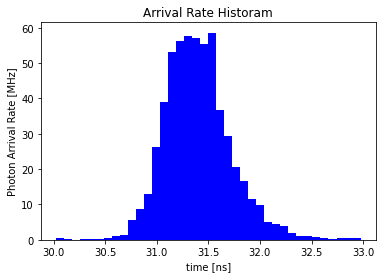

In [4]:
# Scaled time-of-flight histogram
fig = plt.figure()
ax = fig.add_subplot(111)
n, bins = np.histogram(flight_time/1000, bins=38)
binwidth = np.diff(bins)[0]
N = n / binwidth / 1e-9 / cnt_phot_fit  # [Hz] Scaling counts to arrival rate
center = 0.5 * (bins[:-1] + bins[1:])
ax.bar(center, N/1e6, align='center', width=binwidth, color='b')
ax.set_title('Arrival Rate Historam')
ax.set_xlabel('time [ns]')
ax.set_ylabel('Photon Arrival Rate [MHz]')
plt.show()

#### Now transitioning to applying the curve_fit routine to my data. Code pulled from Matt Hayman's "Fit_TimeTag_Gaussian.ipynb"

In [17]:
# build the fit model as a NN module
class Fit_Pulse(torch.nn.Module):
    def __init__(self,t_max):
        """
        Instantiate and initialize the fit parameters.
        """
        super().__init__()
        self.log_A = torch.nn.Parameter(21.82*torch.ones(()))    # Gaussian amplitude
        self.log_mu = torch.nn.Parameter(-17.28*torch.ones(()))  # Gaussian mean
        self.log_sig = torch.nn.Parameter(-21.4*torch.ones(()))   # Gaussian std
        self.log_b = torch.nn.Parameter(1*torch.ones(()))       # background
        self.t_max = t_max  # Time elapsed per shot
        
        self.sqrt_2pi = torch.sqrt(torch.tensor(2*np.pi))
        self.sqrt_2  = torch.sqrt(torch.tensor(2.0))
        

    def forward(self, t):
        """
        Forward model the profile for input time t.
        Also return the integral.
        """
        # calculate all the actual fit parameters
        A = torch.exp(self.log_A)
        mu = torch.exp(self.log_mu)
        sig = torch.exp(self.log_sig)
        b = torch.exp(self.log_b)
        
        # calculate the forward model
        model_out = A*torch.exp(-1*(t-mu)**2/(2*sig**2)) + b
        
        # calculate the integral
        integral_out = b*self.t_max \
                        + 0.5*A*sig*self.sqrt_2pi \
                        + 0.5*A*sig*self.sqrt_2pi\
                            *torch.special.erf((self.t_max-mu)/(sig*self.sqrt_2))
            
        return model_out, integral_out

In [18]:
def pois_loss(prof,integral):
    """
    Poisson point process loss function
    prof: estimated photon arrival rate evaluated at
        each time tag
    integral: integral of prof at t_max
    """
    return integral-torch.sum(torch.log(prof))

In [19]:
# optimization parameters

rel_step_lim = 1e-15  # termination criteria based on step size
max_epochs = 5000     # maximum number of iterations/epochs
learning_rate = 1e-2  # ADAM learning rate
term_persist = 20     # relative step size averaging interval in iterations

In data set, the frequency of the sync pulses is ~14.2kHz. Therefore, t_max ~= 70.2043 usec. Might need to look into having this dynamically adjusted.

In [20]:
# I define the maximum time as a fixed value. This is the mode of the recorded elapsed time between shots.
# Time vector per shot (sync event)
t_min = 0
avg_sync_diff = ds.sync_delta.mean() * tstamp_int / 1e12  # [s]
t_max = avg_sync_diff.item()
dt = tstamp_int * 1e-12                                    # [s]
t_fine = np.arange(t_min, t_max, dt)

In [21]:
# initialize for fit loop
fit_model = Fit_Pulse(t_max)
optimizer = torch.optim.Adam(fit_model.parameters(), lr=learning_rate)
epoch = 0
rel_step = 1e3*rel_step_lim
train_loss_lst = []
rel_step_lst = []

init_log_A = fit_model.log_A.item()
init_log_mu = fit_model.log_mu.item()
init_log_sig = fit_model.log_sig.item()
init_log_b = fit_model.log_b.item()

In [22]:
# set the loss function to use a 
# Poisson point process likelihood function
loss_fn = pois_loss

In [23]:
t_phot_fit = flight_time * 1e-12  # [s] convert to seconds
t_phot_fit_tnsr = torch.tensor(t_phot_fit.to_numpy())

In [24]:
# perform fit
while rel_step > rel_step_lim and epoch < max_epochs:
    fit_model.train()
    pred, integral = fit_model(t_phot_fit_tnsr)
    loss = loss_fn(pred, integral*cnt_phot_fit)  # add regularization here
    train_loss_lst += [loss.item()]

    # calculate relative step as an average over the last
    # term_persist iterations
    if epoch == 0:
        rel_step_lst+=[1e3*rel_step_lim]
        rel_step = 1e3*rel_step_lim
    else:
        rel_step_lst+=[(train_loss_lst[-2]-train_loss_lst[-1])/np.abs(train_loss_lst[-2])]
        rel_step = np.abs(np.array(rel_step_lst)[-term_persist:].mean())

    # update estimated parameters
    loss.backward()
    optimizer.step()
    
    # zero out the gradient for the next step
    optimizer.zero_grad()
    
    epoch+=1
    

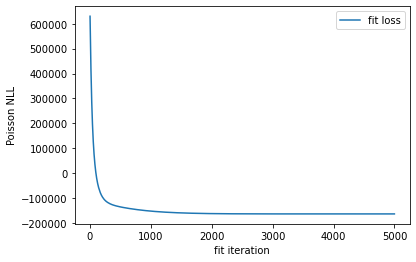

In [25]:
# plot the loss over iterations
plt.figure()
plt.plot(train_loss_lst,label='fit loss')
plt.xlabel('fit iteration')
plt.ylabel('Poisson NLL')
plt.legend()

In [26]:
pred_mod_full, integral_full = fit_model(torch.tensor(t_fine))

In [27]:
print('Initial A: {}'.format(np.exp(init_log_A)))
print('Initial mu: {}'.format(np.exp(init_log_mu)))
print('Initial sig: {}'.format(np.exp(init_log_sig)))
print('Initial b: {}\n'.format(np.exp(init_log_b)))

print('Final A: {}'.format(torch.exp(fit_model.log_A)))
print('Final mu: {}'.format(torch.exp(fit_model.log_mu)))
print('Final sig: {}'.format(torch.exp(fit_model.log_sig)))
print('Final b: {}'.format(torch.exp(fit_model.log_b)))

Initial A: 2994369997.069977
Initial mu: 3.1288954700543776e-08
Initial sig: 5.082744194018594e-10
Initial b: 2.718281828459045

Final A: 55603008.0
Final mu: 3.140177184945969e-08
Final sig: 3.235487711084062e-10
Final b: 0.008243161253631115


In [28]:
print("Sample average arrival time: {:.4f} ns".format(torch.mean(t_phot_fit_tnsr)*1e9))

Sample average arrival time: 31.4021 ns


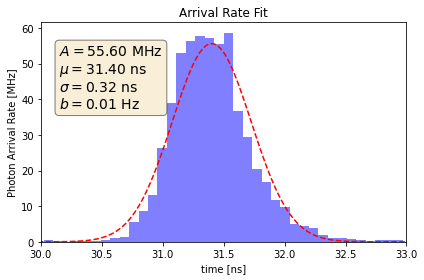

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Scaled histogram
n, bins = np.histogram(flight_time/1000, bins=38)
binwidth = np.diff(bins)[0]
N = n / binwidth / 1e-9 / cnt_phot_fit  # [Hz] Scaling counts to arrival rate
center = 0.5 * (bins[:-1] + bins[1:])
ax.bar(center, N/1e6, align='center', width=binwidth, color='b', alpha=0.5)

# Arrival rate fit
fit_rate = pred_mod_full.detach().numpy()  # [Hz] Fitted arrival rate
ax.plot(t_fine*1e9, fit_rate/1e6,'r--')
ax.set_xlim([30, 33])
ax.set_title('Arrival Rate Fit')
ax.set_xlabel('time [ns]')
ax.set_ylabel('Photon Arrival Rate [MHz]')
textstr = '\n'.join((
    r'$A=%.2f$ MHz' % (torch.exp(fit_model.log_A)*1e-6, ),
    r'$\mu=%.2f$ ns' % (torch.exp(fit_model.log_mu)*1e9, ),
    r'$\sigma=%.2f$ ns' % (torch.exp(fit_model.log_sig)*1e9, ),
    r'$b=%.2f$ Hz' % (torch.exp(fit_model.log_b))))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.tight_layout()
plt.show()



## Graveyard

In [ ]:
# ### CONSTANTS ####
# c = 299792458                      # [m/s] Speed of light
# tstamp_int = 25                    # Timestamp interval (e.g., timestamp recorded in intervals of 25)
# max_rollover = 2**25 * tstamp_int  # [ps] the maximum timestamp before instrument timer rolls over

# ### PARAMETERS ###
# create_csv = False             # Set true to generate a .csv from .ARSENL data
# load_data = True          # Set true to load data into a DataFrame and serialize into a pickle object
# irregular_data = True      # Set true if data has gaps (i.e., dtime is 0 for many clock cycles)
# exclude_bnd = [26000, 40000]   # Set boundaries for binning

In [ ]:
# # Load INPHAMIS .ARSENL data if not yet serialized
# if load_data:
#     load_INPHAMIS_data(data_dir, fname, picklename, create_csv)

# # Unpickle the data to DataFrame object
# infile = open('{}/{}'.format(data_dir, picklename), 'rb')
# df_orig = pickle.load(infile)
# infile.close()

In [ ]:
# # Extract detection and sync events

# df_clean = df_orig.loc[df_orig['dtime'] != 0]  # Ignore data gaps
# df_clean = df_clean[0:10000]

# rollover = df_clean.loc[(df_clean['overflow'] == 1) & \
#                         (df_clean['channel'] == 63)]  # Rollover event ("overflow","channel") = (1,63)
# detect = df_clean.loc[(df_clean['overflow'] == 0) & \
#                       (df_clean['channel'] == 0)]     # Detection events ("overflow","channel") = (0,0)
# sync = df_clean.loc[(df_clean['overflow'] == 1) & \
#                     (df_clean['channel'] == 0)]       # Sync events ("overflow","channel") = (1,0)

# sync_detect_idx = df_orig.index.searchsorted(detect.index, side='left') - 1  # Return idx of sync pulse that caused detection event
# sync_detect = df_orig.loc[sync_detect_idx]

# # If data has gaps then ignore detection events that occur immediately following a data gap,
# # else the sync event prior to the data gap will be adjoined inadvertently.
# if irregular_data:
#     sync_detect = sync_detect.loc[sync_detect['dtime'] != 0]
#     detect = df_clean.loc[sync_detect.index + 1]

In [ ]:
# print("Number of\n")
# print("\tsync events: {}".format(len(sync.index)))
# print("\tdetection events: {}".format(len(detect.index)))
# print("\trollovers: {}".format(len(rollover.index)))

In [ ]:
# # Convert sync/detection events to flight times

# detect_time = detect['dtime'].to_numpy()
# sync_detect_time = sync_detect['dtime'].to_numpy()

# flight_time = (detect_time - sync_detect_time) * tstamp_int  # [ps] Time is in segments of 25 ps
# flight_time = flight_time[np.where((flight_time >= exclude_bnd[0]) \
#                                    & (flight_time < exclude_bnd[1]))]  # Exclude specified t.o.f. bins

# distance = flight_time / 1e12 * c / 2

# cnt_phot_fit = len(sync.index)